In [1]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Voronoi

# k=5 # The number of clusters that you want to find
# kmeans = KMeans(n_clusters=k)
# y_pred = kmeans.fit_predict(X) # Assigns each instance to a group from 0-4

# kmeans.cluster_centers_ # Reveals the centroids of each cluster

# kmeans.predict(X_test) # Assigns each test value to a cluster

In [3]:
np.random.seed(1234)
points = np.random.rand(15, 2)
points

array([[0.19151945, 0.62210877],
       [0.43772774, 0.78535858],
       [0.77997581, 0.27259261],
       [0.27646426, 0.80187218],
       [0.95813935, 0.87593263],
       [0.35781727, 0.50099513],
       [0.68346294, 0.71270203],
       [0.37025075, 0.56119619],
       [0.50308317, 0.01376845],
       [0.77282662, 0.88264119],
       [0.36488598, 0.61539618],
       [0.07538124, 0.36882401],
       [0.9331401 , 0.65137814],
       [0.39720258, 0.78873014],
       [0.31683612, 0.56809865]])

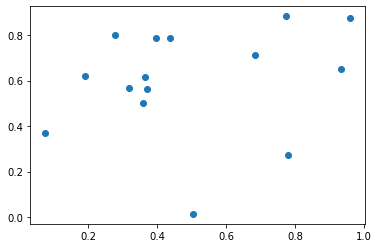

In [6]:
X = [i[0] for i in points]
y = [i[1] for i in points]
plt.scatter(X, y)

In [8]:
vor = Voronoi(points)
vor

In [9]:
def voronoi_finite_polygons_2d(vor, radius=None):
    """
    Reconstruct infinite voronoi regions in a 2D diagram to finite
    regions.

    Parameters
    ----------
    vor : Voronoi
        Input diagram
    radius : float, optional
        Distance to 'points at infinity'.

    Returns
    -------
    regions : list of tuples
        Indices of vertices in each revised Voronoi regions.
    vertices : list of tuples
        Coordinates for revised Voronoi vertices. Same as coordinates
        of input vertices, with 'points at infinity' appended to the
        end.

    """

    if vor.points.shape[1] != 2:
        raise ValueError("Requires 2D input")

    new_regions = []
    new_vertices = vor.vertices.tolist()

    center = vor.points.mean(axis=0)
    if radius is None:
        radius = vor.points.ptp().max()*2

    # Construct a map containing all ridges for a given point
    all_ridges = {}
    for (p1, p2), (v1, v2) in zip(vor.ridge_points, vor.ridge_vertices):
        all_ridges.setdefault(p1, []).append((p2, v1, v2))
        all_ridges.setdefault(p2, []).append((p1, v1, v2))

    # Reconstruct infinite regions
    for p1, region in enumerate(vor.point_region):
        vertices = vor.regions[region]

        if all([v >= 0 for v in vertices]):
            # finite region
            new_regions.append(vertices)
            continue

        # reconstruct a non-finite region
        ridges = all_ridges[p1]
        new_region = [v for v in vertices if v >= 0]

        for p2, v1, v2 in ridges:
            if v2 < 0:
                v1, v2 = v2, v1
            if v1 >= 0:
                # finite ridge: already in the region
                continue

            # Compute the missing endpoint of an infinite ridge

            t = vor.points[p2] - vor.points[p1] # tangent
            t /= np.linalg.norm(t)
            n = np.array([-t[1], t[0]])  # normal

            midpoint = vor.points[[p1, p2]].mean(axis=0)
            direction = np.sign(np.dot(midpoint - center, n)) * n
            far_point = vor.vertices[v2] + direction * radius

            new_region.append(len(new_vertices))
            new_vertices.append(far_point.tolist())

        # sort region counterclockwise
        vs = np.asarray([new_vertices[v] for v in new_region])
        c = vs.mean(axis=0)
        angles = np.arctan2(vs[:,1] - c[1], vs[:,0] - c[0])
        new_region = np.array(new_region)[np.argsort(angles)]

        # finish
        new_regions.append(new_region.tolist())

    return new_regions, np.asarray(new_vertices)

(-0.08623155040931776, 0.9826411906361165)

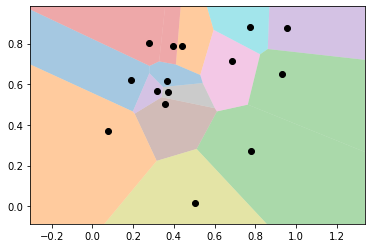

In [12]:
# plot
regions, vertices = voronoi_finite_polygons_2d(vor)
# print("--")
# print(regions)
# print("--")
# print(vertices)

# colorize
for region in regions:
    polygon = vertices[region]
    plt.fill(*zip(*polygon), alpha=0.4)

plt.plot(points[:,0], points[:,1], 'ko')
plt.axis('equal')
plt.xlim(vor.min_bound[0] - 0.1, vor.max_bound[0] + 0.1)
plt.ylim(vor.min_bound[1] - 0.1, vor.max_bound[1] + 0.1)

In [32]:
from matplotlib.image import imread
import matplotlib.pyplot as plt
import os
from sklearn.cluster import KMeans
from PIL import Image as im

image = imread("ladybug.png")
image.shape # Height, Width, Color Channels

(533, 800, 3)

In [33]:
X = image.reshape(-1, 3)
kmeans = KMeans(n_clusters=8, random_state=42).fit(X)
segmented_img = kmeans.cluster_centers_[kmeans.labels_]
segmented_img = segmented_img.reshape(image.shape)

segmented_imgs = []
n_colors = (10, 8, 6, 4, 2)
for n_clusters in n_colors:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(X)
    segmented_img = kmeans.cluster_centers_[kmeans.labels_]
    segmented_imgs.append(segmented_img.reshape(image.shape))

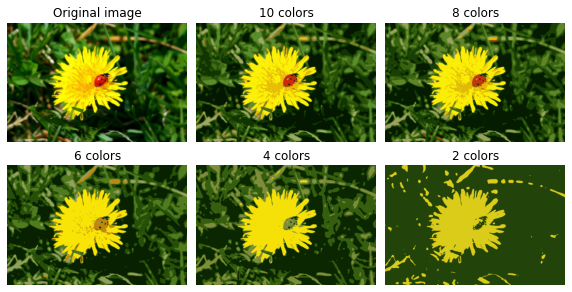

In [37]:
plt.figure(figsize=(10,5))
plt.subplots_adjust(wspace=0.05, hspace=0.1)

plt.subplot(231)
plt.imshow(image)
plt.title("Original image")
plt.axis('off')

for idx, n_clusters in enumerate(n_colors):
    plt.subplot(232 + idx)
    plt.imshow(segmented_imgs[idx])
    plt.title("{} colors".format(n_clusters))
    plt.axis('off')

plt.show()

In [45]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

X_digits, y_digits = load_digits(return_X_y = True)

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)

log_reg = LogisticRegression()

log_reg.fit(X_train, y_train)

/opt/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [42]:
log_reg.score(X_test, y_test) # Our baseline score

0.9777777777777777

In [43]:
pipeline = Pipeline([
    ("kmeans", KMeans(n_clusters=50)),
    ("log_reg", LogisticRegression())
])

pipeline.fit(X_train, y_train)

/opt/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('kmeans', KMeans(n_clusters=50)),
                ('log_reg', LogisticRegression())])

In [44]:
pipeline.score(X_test, y_test)

0.9644444444444444

In [47]:
param_grid = dict(kmeans__n_clusters=range(2, 100))

grid_clf = GridSearchCV(pipeline, param_grid, cv=3)
grid_clf.fit(X_train, y_train)

grid_clf.best_params_

/opt/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/miniconda3/envs/minimal_ds/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.

{'kmeans__n_clusters': 77}

In [48]:
grid_clf.best_params_

{'kmeans__n_clusters': 77}

In [106]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
import numpy as np

X_digits, y_digits = load_digits(return_X_y = True)

X_train, X_test, y_train, y_test = train_test_split(X_digits, y_digits)


k = 50
kmeans = KMeans(n_clusters=k, random_state=42)
X_digits_dist = kmeans.fit_transform(X_train)
representative_digit_idx = np.argmin(X_digits_dist, axis=0)
X_representative_digits = X_train[representative_digit_idx]

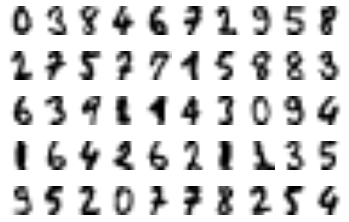

In [113]:
for index, X_representative_digit in enumerate(X_representative_digits):
    plt.subplot(k // 10, 10, index + 1)
    plt.imshow(X_representative_digit.reshape(8, 8), cmap="binary", interpolation="bilinear")
    plt.axis('off')

plt.show()

In [111]:
y_representative_digits = y_train[representative_digit_idx]
y_representative_digits

array([0, 3, 8, 4, 6, 7, 2, 9, 5, 8, 2, 7, 5, 7, 7, 1, 5, 8, 8, 3, 6, 3,
       9, 1, 1, 4, 3, 0, 9, 4, 1, 6, 4, 2, 6, 2, 1, 1, 3, 5, 9, 5, 2, 0,
       7, 7, 8, 2, 5, 4])

In [112]:
# X_representative_digit = X_representative_digit.reshape(-1, 1)
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_representative_digits, y_representative_digits)
log_reg.score(X_test, y_test)

0.8844444444444445

In [ ]:
for i in enumerate(range(0, 1000, 10)):
    print(i)

(0, 0)
(1, 10)
(2, 20)
(3, 30)
(4, 40)
(5, 50)
(6, 60)
(7, 70)
(8, 80)
(9, 90)
(10, 100)
(11, 110)
(12, 120)
(13, 130)
(14, 140)
(15, 150)
(16, 160)
(17, 170)
(18, 180)
(19, 190)
(20, 200)
(21, 210)
(22, 220)
(23, 230)
(24, 240)
(25, 250)
(26, 260)
(27, 270)
(28, 280)
(29, 290)
(30, 300)
(31, 310)
(32, 320)
(33, 330)
(34, 340)
(35, 350)
(36, 360)
(37, 370)
(38, 380)
(39, 390)
(40, 400)
(41, 410)
(42, 420)
(43, 430)
(44, 440)
(45, 450)
(46, 460)
(47, 470)
(48, 480)
(49, 490)
(50, 500)
(51, 510)
(52, 520)
(53, 530)
(54, 540)
(55, 550)
(56, 560)
(57, 570)
(58, 580)
(59, 590)
(60, 600)
(61, 610)
(62, 620)
(63, 630)
(64, 640)
(65, 650)
(66, 660)
(67, 670)
(68, 680)
(69, 690)
(70, 700)
(71, 710)
(72, 720)
(73, 730)
(74, 740)
(75, 750)
(76, 760)
(77, 770)
(78, 780)
(79, 790)
(80, 800)
(81, 810)
(82, 820)
(83, 830)
(84, 840)
(85, 850)
(86, 860)
(87, 870)
(88, 880)
(89, 890)
(90, 900)
(91, 910)
(92, 920)
(93, 930)
(94, 940)
(95, 950)
(96, 960)
(97, 970)
(98, 980)
(99, 990)


In [121]:
kmeans.labels_

array([ 3, 18, 20, ..., 28, 46,  0], dtype=int32)

In [130]:
len(X_cluster_dist)

1347

In [131]:
y_train_propagated = np.empty(len(X_train), dtype=np.int32)
for i in range(k):
    y_train_propagated[kmeans.labels_==i] = y_representative_digits[i]
    # print(y_train_propagated[kmeans.labels_==i])

percentile_closest = 20

X_cluster_dist = X_digits_dist[np.arange(len(X_train)), kmeans.labels_]
for i in range(k):
    in_cluster = (kmeans.labels_ == i)
    print(kmeans.labels_ == i)
    cluster_dist = X_cluster_dist[in_cluster]
    cutoff_distance = np.percentile(cluster_dist, percentile_closest)
    above_cutoff = (X_cluster_dist > cutoff_distance)
    X_cluster_dist[in_cluster & above_cutoff] = -1

[False False False ... False False  True]
[False False False ... False False False]
[False False False ... False False False]
[ True False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False  True False ... False False False]
[False False False ... False False False]
[False False  True ... False False False]
[False False False ... False False False]
[False False False ... False False False]
[False False False ... False False

In [123]:
partially_propagated = (X_cluster_dist != -1)
X_train_partially_propagated = X_train[partially_propagated]
y_train_partially_propagated = y_train_propagated[partially_propagated]

In [124]:
log_reg = LogisticRegression(multi_class="ovr", solver="lbfgs", max_iter=5000, random_state=42)
log_reg.fit(X_train_partially_propagated, y_train_partially_propagated)

LogisticRegression(max_iter=5000, multi_class='ovr', random_state=42)

In [125]:
log_reg.score(X_test, y_test)

0.9088888888888889

In [126]:
np.empty(len(X_train), dtype=np.int32)

array([         0,          0, -805306238, ...,          6,          6,
                7], dtype=int32)

In [132]:
from sklearn.mixture import GaussianMixture

gm = GaussianMixture(n_components=3, n_init=10)

gm.fit(X_train)

GaussianMixture(n_components=3, n_init=10)

In [136]:
gm.weights_

array([0.10096511, 0.04380102, 0.85523387])

In [134]:
X_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  5., ..., 10.,  0.,  0.],
       [ 0.,  0.,  0., ..., 14.,  2.,  0.],
       ...,
       [ 0.,  0.,  7., ...,  7.,  0.,  0.],
       [ 0.,  0.,  7., ...,  5.,  0.,  0.],
       [ 0.,  0.,  2., ...,  6.,  0.,  0.]])

In [ ]:
gm.score()